In [1]:
!nvidia-smi

Tue Apr  6 09:17:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!cat /proc/uptime | awk '{print $1 /60 /60 /24 "days (" $1 "sec)"}'

0.000900116days (77.77sec)


In [3]:
!git clone https://github.com/yours-schnee/custom_ImageNet.git

Cloning into 'custom_ImageNet'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 57 (delta 19), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (57/57), done.


In [4]:
!pip install -e ./custom_ImageNet

ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /content/custom_ImageNet


In [5]:
import sys
sys.path.append('/content/custom_ImageNet')

In [6]:
import custom_ImageNet
from utils.ImageNetDataset import make_path_list
from utils.ImageNetDataset import str_convert
from utils.ImageNetDataset import ImageNetDataset

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import init
from torch.optim import lr_scheduler
from torch import optim

In [8]:
import glob
import os
import time
import shutil
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm

from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.metrics import classification_report
import statistics
import itertools
np.set_printoptions(threshold=np.inf)
#from PIL import Image  
import PIL
import PIL.Image
from PIL import ImageFile

#import copy
from copy import deepcopy
from torchsummary import summary
import torch.utils.data as data
import datetime

!pip install tensorboardX
import tensorboardX as tbx
from tensorboardX import SummaryWriter


     |████████████████████████████████| 122kB 16.1MB/s 


In [9]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
!cp "drive/My Drive/ImageNet/cortical_20random_ImagenetTrain.zip" /content/
!cp "drive/My Drive/ImageNet/cortical_ImagenetTest2.zip" /content/

In [12]:
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [13]:
!7z x cortical_20random_ImagenetTrain.zip

Output hidden; open in https://colab.research.google.com to view.

In [14]:
!mv "content/cortical_ImagenetTrain" ../content

In [15]:
import shutil

directory = 'content'

try:
    shutil.rmtree(directory)
except FileNotFoundError:
    pass

In [16]:
!unzip -nq "cortical_ImagenetTest2.zip"

In [17]:
def make_path_list_png(rootpath):
    """
    To create the list of file path about Image data and annotation data
    for training and test

    Inputs
    --------------------
    rootpath : str
        path data for data folder

    Returns
    --------------------
    *_img_list, *_anno_list
        list of path for each data
    """

    img_list = glob.glob(rootpath+'*/*.png')

    return img_list

In [18]:
rootpathTrain ='cortical_ImagenetTrain/'
rootpathTest ='cortical_ImagenetTest2/'

# Get folder name
train_img_list = make_path_list(rootpathTrain)
test_img_list = make_path_list_png(rootpathTest)

In [19]:
simple_transform = transforms.Compose([transforms.Resize((224,224),interpolation=3),
                                       transforms.ToTensor()])

train_dataset = ImageNetDataset(train_img_list, phase="train", transform=simple_transform)

test_dataset = ImageNetDataset(test_img_list, phase="test",
                          transform=simple_transform)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [20]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)
np.random.seed(6)
device = torch.device("cuda" if use_cuda else "cpu")
#classes_list = train_dataset.get_label_relation()
classes_list = test_dataset.get_label_relation()


In [21]:
batch_size = 32

In [22]:
# training data split to train and val
validation_split = .2

dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

# Creating PT data samplers
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

In [23]:
# dataloder
trainloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)

valloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=2)

#trainloader = data.DataLoader(
#    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

testloader = data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

dataloaders_dict = {"train": trainloader, "val": valloader}

In [24]:
index_dict = {"train": train_idx, "val": valid_idx}
len(index_dict["train"])

283136

In [25]:
"""cnt = 0
for epoch in range(2):
    for images, labels in tqdm(testloader):
        cnt += 1
        if (cnt%10)
        print()"""

'cnt = 0\nfor epoch in range(2):\n    for images, labels in tqdm(testloader):\n        cnt += 1\n        if (cnt%10)\n        print()'

--------------------
(224, 224, 3)


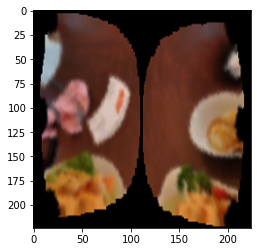

In [26]:
index = 2
imges, label = test_dataset.__getitem__(index)

img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
print("--------------------")
print(img_val.shape)
plt.imshow(img_val)
plt.show()


In [27]:
#code adapted from https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion(cm, classes, name, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    #print(cm)
    filename= name + "_confusion.png"
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/"
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.0f}".format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(path+filename)


In [28]:
def plot_graph(training_losses,val_losses,epochs,string,name):
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel(string)

    filename = name + "_" + string + "_.png" 
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/{filename}"
    plt.title(string + 'per epoch - ' + "Simple classifier")
    
    plt.plot(range(epochs),training_losses,label="Training " + string)
    plt.plot(range(epochs),val_losses,label="Validation " + string)
    plt.legend()
    plt.savefig(path+filename)
    print(path+filename)

In [29]:
# This function will test mask image generation, not the difference between original and generated images
  
def test_model(model, criterion, name):

    model.eval()
    test_epoch_loss = 0
    test_correct = 0
    best_accuracy = 0
    class_correct = list(0 for i in range(N_CLASSES))
    class_total = list(0 for i in range(N_CLASSES))
    mean_accuracies = list(0 for i in range(n_iterations))
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    labelslist=torch.zeros(0,dtype=torch.long, device='cpu')

    with torch.no_grad():
        accuracies = [[] for i in range(n_iterations)]
        #for index,(images, anno, labels) in enumerate(testloader):
        for index,(images, labels) in enumerate(testloader):
            images, labels = images.cuda(), labels.cuda()

            predicted = model(images)
            loss = criterion(predicted,labels)

            test_epoch_loss += loss.item()

            best_predicted = predicted
            _, predicted_l = torch.max(best_predicted.data, 1)
            test_correct += (predicted_l == labels).sum().item()
            c = (predicted_l == labels).squeeze()

            predlist=torch.cat([predlist,predicted_l.view(-1).cpu()])
            labelslist=torch.cat([labelslist,labels.view(-1).cpu()])

            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    test_epoch_loss /= len(testloader)
    print('\nTest loss: {:.4f} \nTesting Accuracy: {}/{} ({:.2f}%)'.format(
          test_epoch_loss, test_correct, len(testloader.dataset),
          100. * test_correct / len(testloader.dataset)))
    for i in range(N_CLASSES):
        print("{} Class Accuracy: {}/{} ({:.2f}%)".format(classes_list[i],class_correct[i],class_total[i],100*class_correct[i]/class_total[i]))

    precision = precision_score(predlist.numpy(), labelslist.numpy(), average='macro')
    recall = recall_score(predlist.numpy(), labelslist.numpy(), average='macro')
    accuracy = accuracy_score(predlist.numpy(), labelslist.numpy())
    f1 = fbeta_score(predlist.numpy(), labelslist.numpy(), 1, average='macro') #1 means f_1 measure
    print("Classifier has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (accuracy,precision,recall,f1))
    conf_matrix=confusion_matrix(labelslist.numpy(), predlist.numpy())
    plt.figure(figsize=(8, 8))
    plot_confusion(conf_matrix, classes_list, name, 'Confusion matrix')
    print(classification_report(labelslist.numpy(), predlist.numpy(),target_names=classes_list))

    return mean_accuracies

In [30]:
def train_model(model, dataloaders_dict, criterion, optimizer, num_epochs, name, folder_name, debug_mode=False):
    
    log_path = F"/content/drive/My Drive/Colab Notebooks/Log/"
    now = datetime.datetime.now()
    folder = F"{name}"+now.strftime('%Y%m%d_%H%M%S')

    writer = tbx.SummaryWriter(log_path+folder)

    global best_accuracy;
    global training_losses; global val_losses;
    global train_accuracies; global val_accuracies;
    global epochs;
    global stats;
    train_loss=0; val_loss=0; train_acc=0; val_acc=0; 
    for epoch in range(epochs,num_epochs):
        epoch = epoch + 1
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')

        # loop for training and validation every epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # training mode
            else:
                model.eval()    # validation mode

            epoch_loss = 0.0    # epoch loss
            epoch_acc = 0       # epoch correct

            #for images, anno, labels in tqdm(dataloaders_dict[phase]):
            for images, labels in tqdm(dataloaders_dict[phase]):
                #images, anno, labels = images.cuda(), anno.cuda(), labels.cuda()
                images, labels = images.cuda(), labels.cuda()
      
                # initialize optimizer
                optimizer.zero_grad()

                # feedforward calc
                with torch.set_grad_enabled(phase == 'train'):
                    predicted = model(images)
                    loss = criterion(predicted, labels)       # loss calc
                    preds = predicted.max(1,keepdim=True)[1]  # label preds

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # calc of iter results
                    epoch_loss += loss.item()
                    epoch_acc += preds.eq(labels.view_as(preds)).sum().item()

            #print(epoch_acc)
            epoch_loss = epoch_loss / len(index_dict[phase])
            epoch_acc = epoch_acc / len(index_dict[phase]) *100.
            
            # stats data save
            if phase == 'train':
                training_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
                train_loss=epoch_loss; train_acc=epoch_acc;
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)
                val_loss=epoch_loss; val_acc=epoch_acc;

                # best model save
                if (epoch_acc > best_accuracy) and debug_mode==False:
                    best_accuracy = epoch_acc
                    best_model = deepcopy(model)
                    
                    path = F"/content/drive/My Drive/Colab Notebooks/PhD/{folder_name}/{name}.tar"
                    torch.save({"best_model":model.state_dict(),
                                "best_acc":best_accuracy
                                },path)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        if epoch%2==0:
            # Colab's disconnection timing while saving data might cause the broken save data against our hope.
            # So, results every epochs will be saved every epochs.
            
            total_name = name+"_epoch"+str(epoch)+".tar"

            path = F"/content/drive/My Drive/Colab Notebooks/PhD/{folder_name}/{total_name}"
            torch.save({
                "epoch":epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "train_loss":training_losses,
                "val_loss":val_losses,
                "train_acc":train_accuracies,
                "val_acc":val_accuracies
                }, path)
            
        print('-------------')
        writer.add_scalars('/loss', {'train_loss': train_loss,
                                     'val_loss': val_loss
                                    }, epoch)
      
        writer.add_scalars('/acc', {'train_acc': train_acc,
                                    'val_acc': val_acc
                                    }, epoch)

    print("Lowest training loss", min(training_losses))
    print("Lowest validation loss", min(val_losses))
    print("Highest training accuracy",max(train_accuracies))
    print("Highest validation accuracy",max(val_accuracies))
    print('-------------')

    stats.append(training_losses)
    stats.append(train_accuracies)
    stats.append(val_losses)
    stats.append(val_accuracies)

    return best_model, stats

### CONST data

In [31]:
# for FC layer's input size computation
img_shapes = [224, 224]

DEBUG = False
if DEBUG:
    NUM_EPOCS = 2
else:
    NUM_EPOCS = 30

n_iterations = 50
N_CLASSES = 20
FC_H = img_shapes[0]//2**4 # 4 is max plling layer num
FC_W = img_shapes[1]//2**4

### Model preparation

### Loss function

In [32]:
# Loss fuc setting
criterion = nn.CrossEntropyLoss()

### VGG11 fine tuning

In [33]:
# Load pre-trained VGG-11
use_pretrained = True
net = models.vgg11(pretrained=use_pretrained)

# Replacement last layer output for 20 classes
net.classifier[6] = nn.Linear(in_features=4096, out_features=N_CLASSES)

net.cuda()

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /root/.cache/torch/hub/checkpoints/vgg11-bbd30ac9.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [34]:
# Store parameters through transfer learning, which are re-trained
params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

# Re-trained params
update_param_names_1 = ["features"]
update_param_names_2 = ["classifier.0.weight",
                        "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
update_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]

# Non re-trained params keep their grads
for name, param in net.named_parameters():
    if update_param_names_1[0] in name:
        param.requires_grad = True
        params_to_update_1.append(param)
        print("params_to_update_1 stores：", name)

    elif name in update_param_names_2:
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2 stores：", name)

    elif name in update_param_names_3:
        param.requires_grad = True
        params_to_update_3.append(param)
        print("params_to_update_3 stores：", name)

    else:
        param.requires_grad = False
        print("Freazed：", name)

params_to_update_1 stores： features.0.weight
params_to_update_1 stores： features.0.bias
params_to_update_1 stores： features.3.weight
params_to_update_1 stores： features.3.bias
params_to_update_1 stores： features.6.weight
params_to_update_1 stores： features.6.bias
params_to_update_1 stores： features.8.weight
params_to_update_1 stores： features.8.bias
params_to_update_1 stores： features.11.weight
params_to_update_1 stores： features.11.bias
params_to_update_1 stores： features.13.weight
params_to_update_1 stores： features.13.bias
params_to_update_1 stores： features.16.weight
params_to_update_1 stores： features.16.bias
params_to_update_1 stores： features.18.weight
params_to_update_1 stores： features.18.bias
params_to_update_2 stores： classifier.0.weight
params_to_update_2 stores： classifier.0.bias
params_to_update_2 stores： classifier.3.weight
params_to_update_2 stores： classifier.3.bias
params_to_update_3 stores： classifier.6.weight
params_to_update_3 stores： classifier.6.bias


In [35]:
vgg_optimizer2 = optim.SGD([
    {'params': params_to_update_1, 'lr': 1e-4},
    {'params': params_to_update_2, 'lr': 5e-4},
    {'params': params_to_update_3, 'lr': 1e-3}
], momentum=0.9)

In [36]:
LOAD_STATE = False
EPOCH = 24             # This values need to check the latest tar ffile name with epoch.
name = "06_VGG11_fine"
folder_name = "VGG11"

if LOAD_STATE:
    stats=[];
    
    PATH1 =  F"/content/drive/My Drive/Colab Notebooks/PhD/{folder_name}/{name}.tar"

    checkpoint = torch.load(PATH1)
    use_pretrained = True
    best_model =net
    best_model.cuda()
    best_model.load_state_dict( checkpoint["best_model"] )
    best_accuracy = 0#checkpoint["best_acc"]

    # Colab's disconnection timing while saving data might cause the broken save data against our hope.
    # So, results every epochs will be saved every epochs.
    total_name = name+"_epoch"+str(EPOCH)+".tar"
    PATH2 =  F"/content/drive/My Drive/Colab Notebooks/PhD/{folder_name}/{total_name}"

    checkpoint = torch.load(PATH2)
    epochs = checkpoint["epoch"]
    net.load_state_dict( checkpoint["model_state_dict"] )
    vgg_optimizer2.load_state_dict( checkpoint["optimizer_state_dict"] )
    training_losses = checkpoint["train_loss"]; val_losses = checkpoint["val_loss"];
    train_accuracies = checkpoint["train_acc"]; val_accuracies = checkpoint["val_acc"];
    stats.append(training_losses)
    stats.append(train_accuracies)
    stats.append(val_losses)
    stats.append(val_accuracies)

else:
    # start point
    best_model=net;
    best_accuracy = 0;
    training_losses = []; val_losses = [];
    train_accuracies = []; val_accuracies = [];
    stats=[];
    epochs=0;


In [37]:
best_vgg2, stats_vgg2 = train_model(net, dataloaders_dict, criterion, vgg_optimizer2, NUM_EPOCS, name, folder_name, DEBUG)

Epoch 1/30
-------------



train Loss: 0.0365 Acc: 62.2849



val Loss: 0.0271 Acc: 71.9612
-------------
Epoch 2/30
-------------



train Loss: 0.0258 Acc: 72.9611



val Loss: 0.0229 Acc: 75.9578
-------------
Epoch 3/30
-------------



train Loss: 0.0211 Acc: 77.6433



val Loss: 0.0196 Acc: 79.3315
-------------
Epoch 4/30
-------------



train Loss: 0.0174 Acc: 81.5255



val Loss: 0.0172 Acc: 82.0256
-------------
Epoch 5/30
-------------



train Loss: 0.0140 Acc: 85.0630



val Loss: 0.0152 Acc: 84.0727
-------------
Epoch 6/30
-------------



train Loss: 0.0110 Acc: 88.2120



val Loss: 0.0138 Acc: 85.5688
-------------
Epoch 7/30
-------------



train Loss: 0.0083 Acc: 91.0725



val Loss: 0.0125 Acc: 87.2372
-------------
Epoch 8/30
-------------



train Loss: 0.0062 Acc: 93.2661



val Loss: 0.0119 Acc: 88.0580
-------------
Epoch 9/30
-------------



train Loss: 0.0046 Acc: 94.9862



val Loss: 0.0116 Acc: 88.8958
-------------
Epoch 10/30
-------------



train Loss: 0.0036 Acc: 96.1400



val Loss: 0.0114 Acc: 89.1459
-------------
Epoch 11/30
-------------



train Loss: 0.0028 Acc: 96.9802



val Loss: 0.0114 Acc: 89.7364
-------------
Epoch 12/30
-------------



train Loss: 0.0022 Acc: 97.6845



val Loss: 0.0116 Acc: 89.8310
-------------
Epoch 13/30
-------------



train Loss: 0.0018 Acc: 98.1129



val Loss: 0.0116 Acc: 90.3227
-------------
Epoch 14/30
-------------



train Loss: 0.0015 Acc: 98.3831



val Loss: 0.0117 Acc: 90.4880
-------------
Epoch 15/30
-------------



train Loss: 0.0013 Acc: 98.6402



val Loss: 0.0113 Acc: 90.5996
-------------
Epoch 16/30
-------------



train Loss: 0.0011 Acc: 98.8592



val Loss: 0.0116 Acc: 90.4866
-------------
Epoch 17/30
-------------



train Loss: 0.0010 Acc: 98.9708



val Loss: 0.0110 Acc: 91.1294
-------------
Epoch 18/30
-------------



train Loss: 0.0008 Acc: 99.1460



val Loss: 0.0115 Acc: 91.2141
-------------
Epoch 19/30
-------------



train Loss: 0.0008 Acc: 99.2149



val Loss: 0.0113 Acc: 91.3526
-------------
Epoch 20/30
-------------



train Loss: 0.0007 Acc: 99.2919



val Loss: 0.0114 Acc: 91.2325
-------------
Epoch 21/30
-------------



train Loss: 0.0006 Acc: 99.3607



val Loss: 0.0113 Acc: 91.5179
-------------
Epoch 22/30
-------------



train Loss: 0.0006 Acc: 99.3780



val Loss: 0.0116 Acc: 91.3794
-------------
Epoch 23/30
-------------



train Loss: 0.0006 Acc: 99.4285



val Loss: 0.0120 Acc: 91.0446
-------------
Epoch 24/30
-------------



train Loss: 0.0005 Acc: 99.4893



val Loss: 0.0116 Acc: 91.4585
-------------
Epoch 25/30
-------------



train Loss: 0.0005 Acc: 99.5409



val Loss: 0.0114 Acc: 91.6026
-------------
Epoch 26/30
-------------



train Loss: 0.0004 Acc: 99.5811



val Loss: 0.0117 Acc: 91.6365
-------------
Epoch 27/30
-------------



train Loss: 0.0004 Acc: 99.5712



val Loss: 0.0118 Acc: 91.5094
-------------
Epoch 28/30
-------------



train Loss: 0.0004 Acc: 99.6164



val Loss: 0.0119 Acc: 91.6196
-------------
Epoch 29/30
-------------



train Loss: 0.0004 Acc: 99.6129



val Loss: 0.0127 Acc: 91.4246
-------------
Epoch 30/30
-------------



train Loss: 0.0003 Acc: 99.6496



val Loss: 0.0121 Acc: 91.5998
-------------
Lowest training loss 0.000343306741154819
Lowest validation loss 0.011034841169396074
Highest training accuracy 99.6496383363472
Highest validation accuracy 91.6365280289331
-------------


/content/drive/My Drive/Colab Notebooks/Graphs/06_VGG11_fine_Loss _.png06_VGG11_fine_Loss _.png
/content/drive/My Drive/Colab Notebooks/Graphs/06_VGG11_fine_Accuracy _.png06_VGG11_fine_Accuracy _.png


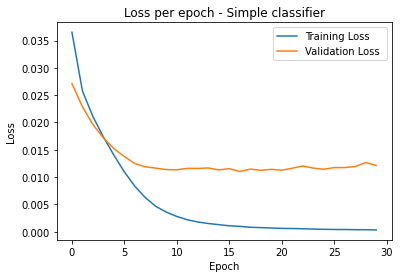

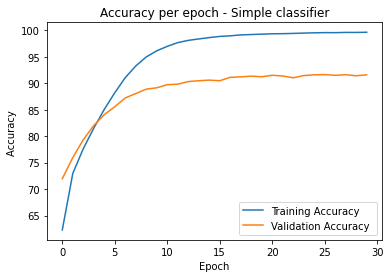

In [38]:
plt.rcParams["figure.figsize"] = (6,4)
plot_graph(stats_vgg2[0],stats_vgg2[2],NUM_EPOCS,"Loss ",name)
plot_graph(stats_vgg2[1],stats_vgg2[3],NUM_EPOCS,"Accuracy ",name)


Test loss: 0.6076 
Testing Accuracy: 1764/2000 (88.20%)
apple Class Accuracy: 85/100 (85.00%)
banana Class Accuracy: 92/100 (92.00%)
bear Class Accuracy: 94/100 (94.00%)
bell_pepper Class Accuracy: 91/100 (91.00%)
bird Class Accuracy: 86/100 (86.00%)
broccoli Class Accuracy: 83/100 (83.00%)
cat Class Accuracy: 92/100 (92.00%)
cauliflower Class Accuracy: 88/100 (88.00%)
cow Class Accuracy: 80/100 (80.00%)
dog Class Accuracy: 79/100 (79.00%)
elephant Class Accuracy: 89/100 (89.00%)
fox Class Accuracy: 88/100 (88.00%)
goat Class Accuracy: 74/100 (74.00%)
horse Class Accuracy: 90/100 (90.00%)
mashed_potato Class Accuracy: 92/100 (92.00%)
orange Class Accuracy: 92/100 (92.00%)
pineapple Class Accuracy: 87/100 (87.00%)
pomegranate Class Accuracy: 96/100 (96.00%)
tomato Class Accuracy: 94/100 (94.00%)
zebra Class Accuracy: 92/100 (92.00%)
Classifier has Acc=0.882 P=0.882 R=0.884 F1=0.882
               precision    recall  f1-score   support

        apple       0.88      0.85      0.86     

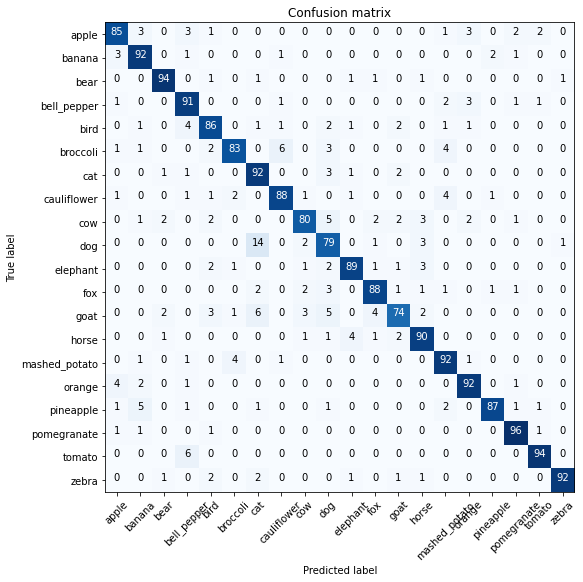

In [39]:
result = test_model(best_vgg2,criterion, name)